# Exercise 3: Logistic Regression

In this exercise we use data of Gorman and Sejnowsk (1988) on submarine sonar signals.
They send sonar signals underwater where there are either just rocks (R) or metal cylindars (M). Think of the metal cylindar as enemy submarines which you try to detect.
The sonar signal is bounced off and energy within a set of frequency bands is measured.

Your goal: use these measurements to find out if the signal bounced off a metal cylindar or a rock.

In [1]:
library(mlbench)
library(glmnet)
library(caret)
data(Sonar)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: lattice
Loading required package: ggplot2


## 1) Logistic regression model
Fit the model `Class ~ .` using `glm` on the entire data set.

Hint: don't forget `family="binomial"`

Does that work?

### Solution:

In [2]:
glm.fit <- glm(Class~.,data=Sonar,family="binomial")

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

## 2) Regularized logistic regression

You have found that the logistic regression algorithm has problems converging. This is not unusual and one of the drawbacks of logistic regression.

**a.** Now try to fit a penalized Elastic Net model with $\alpha=0.5$.
Use Cross-validation to find the CV error minimizing $\lambda$.
Does that work?

Hint: Use `cv.glmnet`. And don't forget to create the model matrix using `model.matrix`.

**b.** Plot the test error as a function of $\lambda$ (Hint: just call `plot` on the object you get from `cv.glmnet`)


### Solution:

In [3]:
x <- model.matrix(Class~.,data=Sonar,family="binomial")
y <- Sonar$Class
cv.fit <- cv.glmnet(x,y,family="binomial",alpha=0.5)

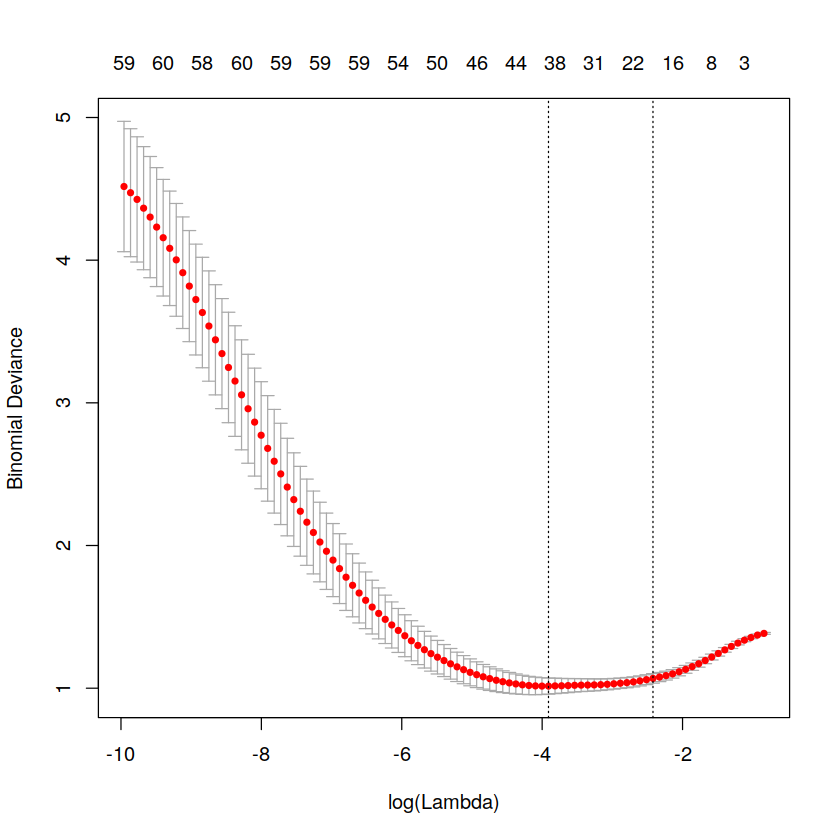

In [4]:
plot(cv.fit)

**c.** Compute the confusion matrix for the 0.5 threshold (Hint: use `confusionMatrix` from the `caret` package)

### Solution:

In [5]:
scores <- predict(cv.fit,newx=x,s=cv.fit$lambda.min)
pred <- as.factor(ifelse(scores>0.5,"R","M"))
confusionMatrix(pred,Sonar$Class)

Confusion Matrix and Statistics

          Reference
Prediction   M   R
         M 106  24
         R   5  73
                                          
               Accuracy : 0.8606          
                 95% CI : (0.8059, 0.9046)
    No Information Rate : 0.5337          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7164          
 Mcnemar's Test P-Value : 0.0008302       
                                          
            Sensitivity : 0.9550          
            Specificity : 0.7526          
         Pos Pred Value : 0.8154          
         Neg Pred Value : 0.9359          
             Prevalence : 0.5337          
         Detection Rate : 0.5096          
   Detection Prevalence : 0.6250          
      Balanced Accuracy : 0.8538          
                                          
       'Positive' Class : M               
                                          

**d.** Plot the ROC curve. (Hint: Use the `ROCR` package

### Solutions:

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



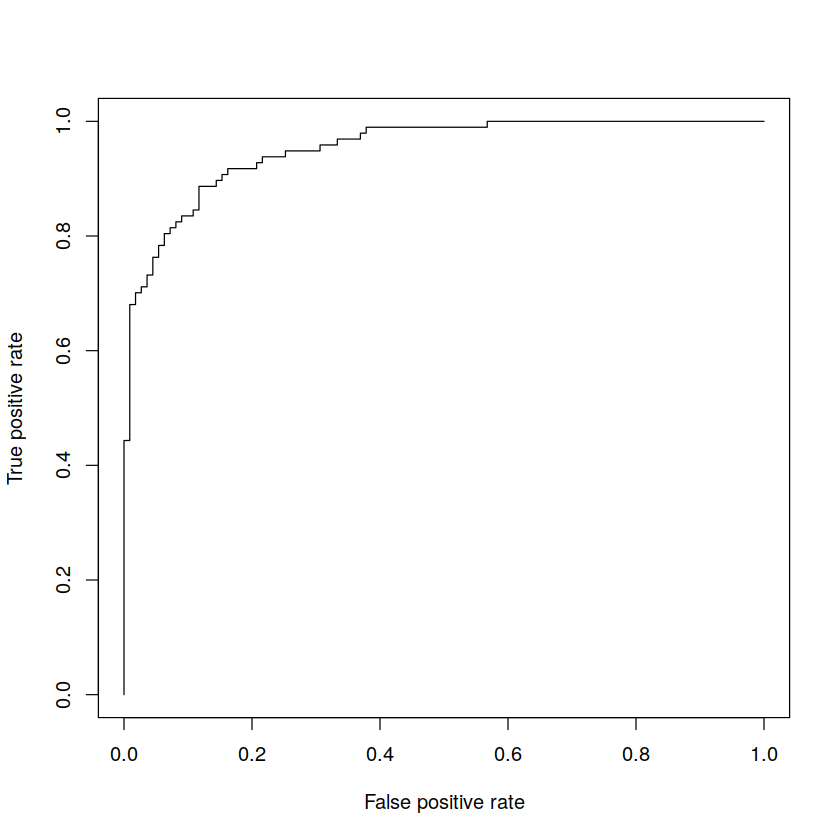

In [6]:
library(ROCR)
predi <- prediction(scores,Sonar$Class)
perf <- performance(predi,"tpr","fpr")
plot(perf)

## 3. SVM
In this exercise we are going to train a Support Vector Machine with a Gaussian kernel on the `Sonar` data.

Your task is to train a SVM and choose the parameter $\gamma$ with 10-fold Cross-validation.
Plot the CV error on $\gamma$. 

Hint: interesting values of $\gamma$ can be very small. It may be fruitful to use an exponentially-spaced grid for $\gamma$ 

In [7]:
library(e1071)
folds <- createFolds(Sonar$Class,10)
gamma.grid <- exp(seq(-6,-3,length.out=20))
error <- matrix(nrow=length(gamma.grid),ncol=length(folds))

for(f in seq_along(folds)) {
    for(i in seq_along(gamma.grid)) {
        svm.fit <- svm(Class~.,data=Sonar[folds[[f]],],kernel="radial",gamma=gamma.grid[[i]])
        error[i,f] <- sum(predict(svm.fit,newdata=Sonar[-folds[[f]],]) != Sonar$Class[-folds[[f]]]) / nrow(Sonar[-folds[[f]],])
    }
}

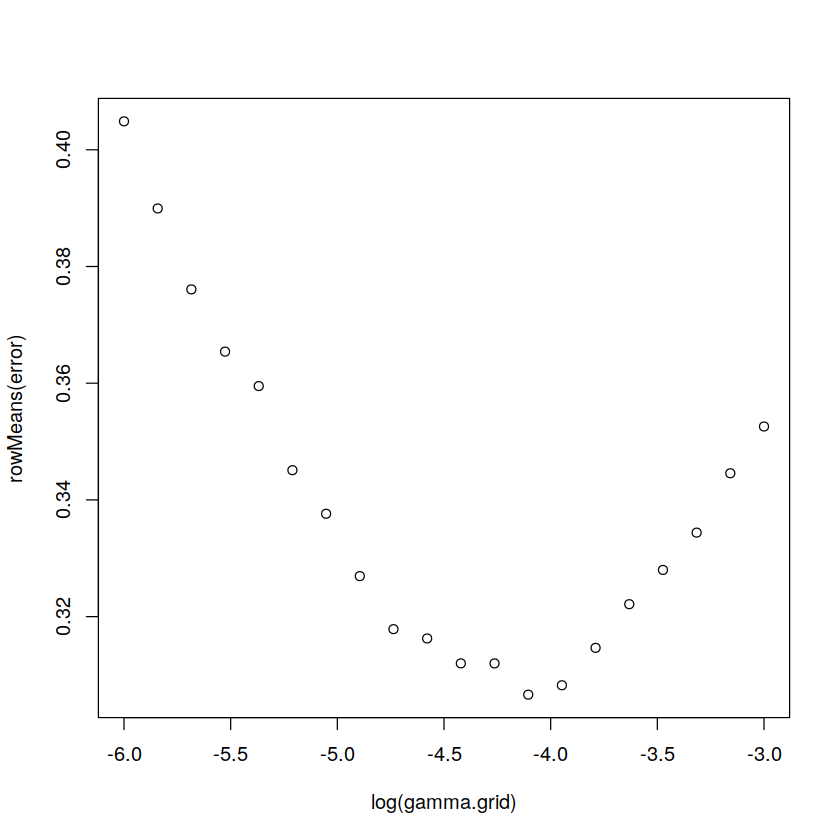

In [8]:
plot(log(gamma.grid),rowMeans(error))